In [9]:
import os
import numpy as np
import pandas as pd

from pyopenms import MSExperiment, MzMLFile
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
from matplotlib import pyplot as plt
import pickle

from mzml_pdiff import load_from_csv
from mzml_pdiff import save_to_csv
from mzml_pdiff import process_file

In [2]:
dir_analyze = "data/"

amino_acid_masses_delta = {
    "G": 57.02146,
    "A": 71.03711,
    "S": 87.03203,
    "P": 97.05276,
    "V": 99.06841,
    "T": 101.04768,
    "C": 103.00919,
    "L": 113.08406,
    "I": 113.08406,
    "N": 114.04293,
    "D": 115.02694,
    "Q": 128.05858,
    "K": 128.09496,
    "E": 129.04259,
    "M": 131.04049,
    "H": 137.05891,
    "F": 147.06841,
    "R": 156.10111,
    "Y": 163.06333,
    "W": 186.07931,
    "C[Carbamidomethyl]": 57.0215,  # Example for "C with carbamidomethyl modification":
    "K[methyl]": 142.1267,  # Example for "K with methyl modification":
    "Q[Pyro-glu]": 128.0586,  # Example for "Q with pyro-glu modification":
    "K[Dimethyl]": 156.1406,  # Example for "K with dimethyl modification":
    "S[Phospho]": 166.9987,  # Example for "S with phospho modification":
    "T[Phospho]": 181.0147,  # Example for "T with phospho modification":
    "Y[Phospho]": 243.0297,  # Example for "Y with phospho modification":
    "K[Trimethyl]": 170.1545,  # Example for "K with trimethyl modification":
    "K[Acetyl]": 170.1055,  # Example for "K with acetyl modification":
    "N[Deamidated]": 115.0270,  # Example for "N with deamidated modification":
    "K[Propionyl]": 184.1194,  # Example for "K with propionyl modification":
    "K[Butyryl]": 198.1333,  # Example for "K with butyryl modification":
    "K[Formyl]": 168.0892,  # Example for "K with formyl modification":
    "K[Oxidation]": 144.1059,  # Example for "K with oxidation modification":
    "K[Malonyl]": 184.1055,  # Example for "K with malonyl modification":
    "K[Succinyl]": 198.1194,  # Example for "K with succinyl modification":
    "R[Methyl]": 170.0914,  # Example for "R with methyl modification":
    "R[Dimethyl]": 184.1053,  # Example for "R with dimethyl modification":
    "R[Trimethyl]": 198.1192,  # Example for "R with trimethyl modification":
    "Q[Deamidated]": 115.0270,  # Example for "Q with deamidated modification":
    "N[Oxidation]": 115.0269,  # Example for "N with oxidation modification":
    "M[Oxidation]": 147.0354,  # Example for "M with oxidation modification":
    "H[Oxidation]": 153.0192,  # Example for "H with oxidation modification":
    "M[Carbamylation]": 125.0477,  # Example for "M with carbamylation modification":
    "N[Amonia-loss]": 113.0473,  # Example for "N with ammonia-loss modification":
    "R[Amonia-loss]": 129.0426,  # Example for "R with ammonia-loss modification":
    "Q[Amonia-loss]": 114.0429,  # Example for "Q with ammonia-loss modification":
    "N[Pyro-glu]": 128.0586,  # Example for "N with pyro-glu modification":
    "K[Pyro-glu]": 128.0949,  # Example for "K with pyro-glu modification":
    "R[Pyro-glu]": 156.1011,  # Example for "R with pyro-glu modification":
}

In [3]:
df_dict = {}
for f in os.listdir(dir_analyze):
    if not f.endswith("_intensities_aa_delta_single_mod.csv"):
        continue
    
    df = pd.read_csv(os.path.join(dir_analyze, f))
    df.index = map(str, df.index)
    df.index = df.index + "|" + f
    df_dict[f] = df

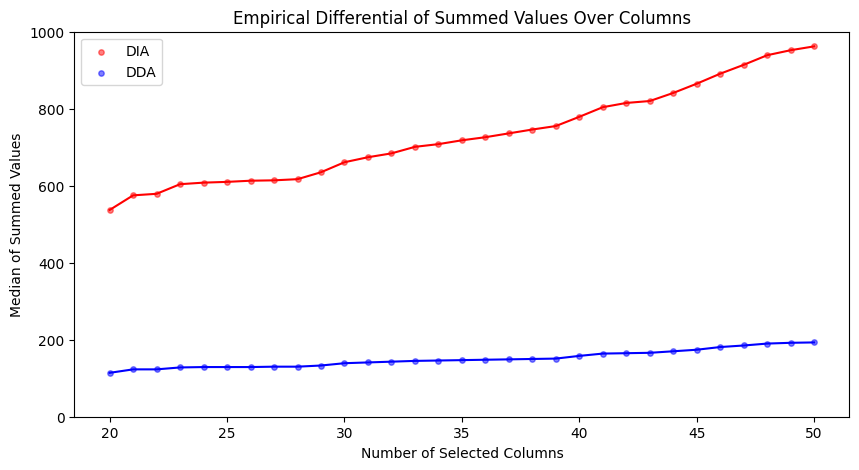

In [4]:
dia_key = "LFQ_Orbitrap_AIF_Human_01_intensities_aa_delta_single_mod.csv"
dda_key = "LFQ_Orbitrap_DDA_Human_01_intensities_aa_delta_single_mod.csv"

# Initialize the figure and axis for the plot
plt.figure(figsize=(10, 5))
ax = plt.gca()

# Lists to store values for plotting the differential
indices = []
dia_median_list = []
dda_median_list = []

for i in range(20, len(amino_acid_masses_delta.keys()) + 1):
    selected_cols = list(amino_acid_masses_delta.keys())[0:i]

    # Calculate the sums of the selected columns
    dia_count_all = df_dict[dia_key][selected_cols].sum(axis=1)
    dda_count_all = df_dict[dda_key][selected_cols].sum(axis=1)

    # Calculate medians for sums greater than 10
    dia_median = dia_count_all[dia_count_all > 10].median()
    dda_median = dda_count_all[dda_count_all > 10].median()

    # Plot each median
    plt.scatter(i, dia_median, c="red", label="DIA" if i == 20 else "", alpha=0.5, s=15)
    plt.scatter(
        i, dda_median, c="blue", label="DDA" if i == 20 else "", alpha=0.5, s=15
    )

    dia_median_list.append(dia_median)
    dda_median_list.append(dda_median)

plt.plot(range(20, len(amino_acid_masses_delta.keys()) + 1), dia_median_list, c="red")
plt.plot(range(20, len(amino_acid_masses_delta.keys()) + 1), dda_median_list, c="blue")

# Setting the plot limits, labels, title, and legend
plt.ylim(0, 1000)
plt.xlabel("Number of Selected Columns")
plt.ylabel("Median of Summed Values")
plt.title("Empirical Differential of Summed Values Over Columns")
plt.legend()

# Show the plot
plt.show()

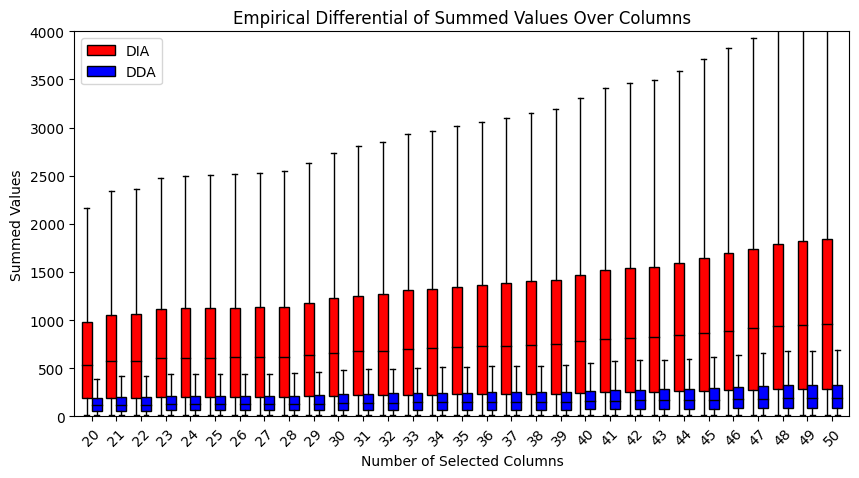

In [5]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

dia_key = "LFQ_Orbitrap_AIF_Human_01_intensities_aa_delta_single_mod.csv"
dda_key = "LFQ_Orbitrap_DDA_Human_01_intensities_aa_delta_single_mod.csv"

# Initialize the figure and axis for the plot
plt.figure(figsize=(10, 5))
ax = plt.gca()

# Lists to store values for plotting the distributions
dia_values = []
dda_values = []
labels = []

for i in range(20, len(amino_acid_masses_delta.keys()) + 1):
    selected_cols = list(amino_acid_masses_delta.keys())[0:i]

    # Calculate the sums of the selected columns
    dia_count_all = df_dict[dia_key][selected_cols].sum(axis=1)
    dda_count_all = df_dict[dda_key][selected_cols].sum(axis=1)

    # Filter sums greater than 10 and collect values
    dia_values.append(dia_count_all[dia_count_all > 10].values)
    dda_values.append(dda_count_all[dda_count_all > 10].values)

    labels.append(str(i))

# Plotting boxplots
positions_dia = [x - 0.2 for x in range(20, len(amino_acid_masses_delta.keys()) + 1)]
positions_dda = [x + 0.2 for x in range(20, len(amino_acid_masses_delta.keys()) + 1)]
central_positions = [x for x in range(20, len(amino_acid_masses_delta.keys()) + 1)]

ax.boxplot(
    dia_values,
    positions=positions_dia,
    widths=0.4,
    patch_artist=True,
    boxprops=dict(facecolor="red"),
    medianprops=dict(color="black"),
    showfliers=False,
)
ax.boxplot(
    dda_values,
    positions=positions_dda,
    widths=0.4,
    patch_artist=True,
    boxprops=dict(facecolor="blue"),
    medianprops=dict(color="black"),
    showfliers=False,
)

# Custom legend
legend_elements = [
    Patch(facecolor="red", edgecolor="black", label="DIA"),
    Patch(facecolor="blue", edgecolor="black", label="DDA"),
]
ax.legend(handles=legend_elements, loc="upper left")

# Setting the plot limits, labels, title, and x-ticks
ax.set_ylim(0, 4000)
ax.set_xlabel("Number of Selected Columns")
ax.set_ylabel("Summed Values")
ax.set_title("Empirical Differential of Summed Values Over Columns")
ax.set_xticks(central_positions)
ax.set_xticklabels(labels, rotation=45)

# Show the plot
plt.show()